### Estimate average velocity from displacement time-series

Given the displacement time-series in meters $d^i, i=1,...,N$, with $d^i = -\frac{\lambda}{4\pi}\phi_{dis}^i$, the average velocity is estimated as:

$d^i = vt_i + c, i=1,...,N$

The standard deviation of the estimated velocity is given by equation (10) in Fattahi and Amelung (2015, JGR) as:

$\sigma_v = \sqrt{\frac{\sum_{i=1}^N (d_i - \hat d_i)^2}{(N-2)\sum_{i=1}^N (t_i - \bar t)^2}}$

Displacement [m]: [ 0.         -0.03170144  0.00123795 -0.06750032 -0.0713983  -0.16640118
 -0.16747225 -0.18887988 -0.23058571 -0.28079049 -0.28220957 -0.26965786
 -0.26315558 -0.29399672 -0.33321417 -0.35032699 -0.29639067 -0.34480032
 -0.30224454 -0.36209858 -0.30835243 -0.31567882 -0.32763482 -0.29892101
 -0.33548711 -0.25030573 -0.30747323 -0.21437314 -0.25346968 -0.25495869
 -0.18305518 -0.21521547 -0.11533086 -0.09118143 -0.06641175 -0.09151583
 -0.01898583  0.00350566  0.08663078  0.15292928  0.15885452  0.16136085
  0.22111896  0.3194404   0.3885217   0.37752631  0.47701671  0.58000493
  0.6064829   0.70781177]
Dates [year]: [2014.5        2014.53285421 2014.56570842 2014.59856263 2014.63141684
 2014.66427105 2014.69712526 2014.72997947 2014.76283368 2014.79568789
 2014.82854209 2014.8613963  2014.89425051 2014.92710472 2014.95995893
 2014.99281314 2015.02566735 2015.05852156 2015.09137577 2015.12422998
 2015.15708419 2015.1899384  2015.22279261 2015.25564682 2015.28850103
 20

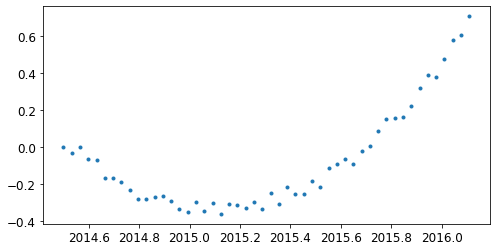

In [7]:
%matplotlib inline
import os
import numpy as np
from scipy import linalg, stats
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

## simulate displacement time-series and dates
vel_sim = 0.1 #m/year
acc_sim = 1.0 #m/year^2
num_date = 50
t_year = np.arange(num_date) * 12 / 365.25 + 2014.5

np.random.seed(65535)
rind = 20
d = (  acc_sim * (t_year - t_year[rind])**2 
     + vel_sim * (t_year - t_year[rind])
     + 0.1 * np.random.rand(num_date))
d -= d[0]

print('Displacement [m]:', d)
print('Dates [year]:', t_year)

# plot
plt.figure(figsize=[8, 4])
plt.plot(t_year, d, '.')
plt.show()

In [12]:
stats.norm.ppf(1 - alpha/2)

1.959963984540054

save figure to file: /Users/yunjunz/tools/utils/MintPy-tutorial/applications/ts2vel.png


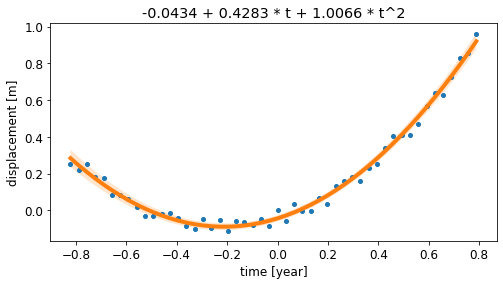

In [15]:
t = t_year
t -= t[25]
d -= d[25]

# design matrix
poly_order = 2
G = np.zeros([len(t), poly_order + 1], dtype=np.float32)
for i in range(poly_order+1):
    G[:,i] = (t**i) / np.math.factorial(i)
num_param = G.shape[1]

# OLS est.
m, e2 = linalg.lstsq(G, d, cond=None)[:2]

m_var_total = e2.flatten() / (num_date - num_param)
m_var = np.dot(np.diag(linalg.inv(np.dot(G.T, G))).reshape(-1, 1), m_var_total)

d_hat = np.dot(G, m)
d_hat_var = np.diag(G.dot(np.diag(m_var)).dot(G.T))

# calc confidence interval
conf_level = 0.995       # confidence interval
alpha = 1 - conf_level  # level of significance
cint_scale = stats.norm.ppf(1 - alpha/2) # scaling factor for confidence interval
d_hat_L = d_hat - cint_scale * np.sqrt(d_hat_var)
d_hat_U = d_hat + cint_scale * np.sqrt(d_hat_var)

title = '{:.4f} + {:.4f} * t + {:.4f} * t^2'.format(m[0], m[1], m[2]/2)

# plot
plt.figure(figsize=[8, 4])
plt.plot(t, d, '.', ms=8)
plt.plot(t, d_hat, '-', color='C1', lw=4, label='estimation')
plt.fill_between(t, d_hat_L, d_hat_U, fc='C1', ec='none', alpha=0.2)

plt.xlabel('time [year]')
plt.ylabel('displacement [m]')
plt.title(title)

out_fig = os.path.abspath(f'ts2vel.png')
print('save figure to file:', out_fig)
plt.savefig(out_fig)
plt.show()

save figure to file: /Users/yunjunz/tools/utils/MintPy-tutorial/applications/ts2vel_pinv_0.png
save figure to file: /Users/yunjunz/tools/utils/MintPy-tutorial/applications/ts2vel_pinv_1.png
save figure to file: /Users/yunjunz/tools/utils/MintPy-tutorial/applications/ts2vel_polyfit_0.png
save figure to file: /Users/yunjunz/tools/utils/MintPy-tutorial/applications/ts2vel_polyfit_1.png


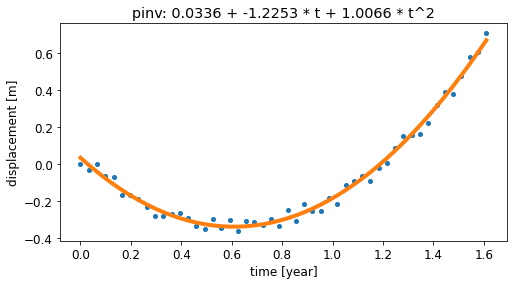

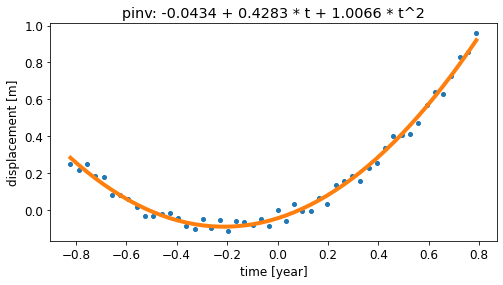

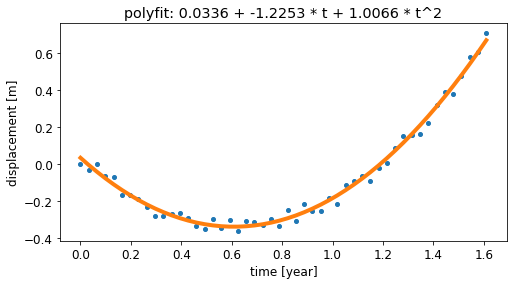

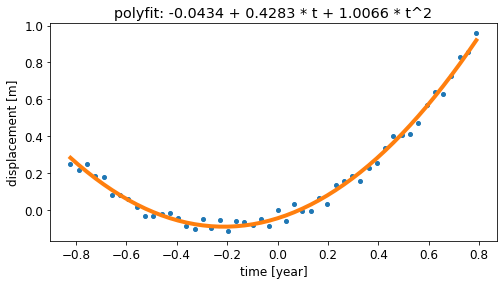

In [2]:
t = t_year

for method in ['pinv', 'polyfit']:
    for n, ind in enumerate([0, 25]):
        t -= t[ind]
        dis_sim -= dis_sim[ind]

        if method == 'pinv':
            poly_order = 2
            G = np.zeros([len(t), poly_order + 1], dtype=np.float32)
            for i in range(poly_order+1):
                G[:,i] = (t**i) / np.math.factorial(i)

            m = np.dot(np.linalg.pinv(G), dis_sim)
            dis_est = np.dot(G, m)
            title = '{}: {:.4f} + {:.4f} * t + {:.4f} * t^2'.format(method, m[0], m[1], m[2]/2)

        elif method == 'polyfit':
            m, stats = P.polyfit(t, dis_sim, 2, full=True)
            dis_est = m[0] + m[1] * t + m[2] * t**2
            title = '{}: {:.4f} + {:.4f} * t + {:.4f} * t^2'.format(method, m[0], m[1], m[2])

        # plot
        plt.figure(figsize=[8, 4])
        plt.plot(t, dis_sim, '.', ms=8)
        plt.plot(t, dis_est, '-', lw=4, label='estimation')
        plt.xlabel('time [year]')
        plt.ylabel('displacement [m]')
        plt.title(title)

        out_fig = os.path.abspath(f'ts2vel_{method}_{n}.png')
        print('save figure to file:', out_fig)
        plt.savefig(out_fig)
plt.show()